In [60]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import datetime
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import tensorflow as tf


In [5]:
#constants
SIZE_CHUNK = 160
CLASS_AMOUNT = 10
THRESHOLDS = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]

In [17]:
TR = pd.read_csv('./data/train_wkt_v4.csv')
GS = pd.read_csv('./data/grid_sizes.csv')
GS = GS.rename( columns={'Unnamed: 0':'ImageId'})

In [5]:
TR

,ImageId,ClassType,MultipolygonWKT
0,6040_2_2,1,MULTIPOLYGON EMPTY
1,6040_2_2,2,MULTIPOLYGON EMPTY
2,6040_2_2,3,MULTIPOLYGON EMPTY
3,6040_2_2,4,MULTIPOLYGON (((0.003025 -0.007879000000000001...
4,6040_2_2,5,MULTIPOLYGON (((0.005311 -0.009044999999999999...
...,...,...,...
245,6100_2_2,6,"MULTIPOLYGON (((0.006102 -0.009042, 0.00642 -0..."
246,6100_2_2,7,MULTIPOLYGON (((0.007887999999999999 -0.009042...
247,6100_2_2,8,"MULTIPOLYGON (((0.002119 -0.001417, 0.002132 -..."
248,6100_2_2,9,"MULTIPOLYGON (((0.008021 -0.003252, 0.00803399..."


In [92]:
len(TR.ImageId.unique())

25

In [6]:
GS

,ImageId,Xmax,Ymin
0,6120_2_4,0.009180,-0.009040
1,6120_2_3,0.009169,-0.009040
2,6120_2_2,0.009188,-0.009040
3,6120_2_1,0.009188,-0.009040
4,6120_2_0,0.009188,-0.009040
...,...,...,...
445,6130_1_4,0.009169,-0.009040
446,6130_1_3,0.009188,-0.009040
447,6130_1_2,0.009150,-0.009042
448,6130_1_1,0.009004,-0.009045


In [91]:
len(GS.ImageId.unique())

450

In [11]:
def adjust_image(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0 
        b = 1
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)

In [12]:
def coords_to_raster(coords, img_size, xmax, ymax):
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / xmax
    yf = H1 / ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

In [13]:
def convert_contours(polygon_list, raster_img_size, xmax, ymin):
    interior_list = []
    exterior_list = []
    if polygon_list is None:
        return None
    for poly in polygon_list:
        perim = np.array(list(poly.exterior.coords))
        rastered_perim = coords_to_raster(perim, raster_img_size, xmax, ymin)
        exterior_list.append(rastered_perim)
        for poly_interiors in poly.interiors:
            interor = np.array(list(poly_interiors.coords))
            rastered_interor = coords_to_raster(interor, raster_img_size, xmax, ymin)
            interior_list.append(rastered_interor)
    return exterior_list, interior_list


In [50]:
def generate_mask(raster_size, img_id, class_type):
    xmax, ymin = GS[GS.ImageId == img_id].iloc[0, 1:].astype(float)
    df_image = TR[TR.ImageId == img_id]
    multipolygon = df_image[df_image.ClassType == class_type].MultipolygonWKT
    polygon_list = None
    polygon_values = multipolygon.values[0]
    if polygon_values != "MULTIPOLYGON EMPTY":
        polygon_list = wkt_loads(polygon_values)

    contours = convert_contours(polygon_list, raster_size, xmax, ymin)
    img_mask = np.zeros(raster_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, 1)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


In [61]:
def augment_and_pack_image(img, mask, dataset_type, augment_amount, augment = True):
    borderline_x, borderline_y = img.shape[0] - SIZE_CHUNK, img.shape[1] - SIZE_CHUNK
    split_amount = int(augment_amount * 0.1)
    augment_amount -= split_amount
    non_augment_amount = split_amount

    x_dataset_augmented = []
    y_dataset_augmented = []
    x_dataset_non_augmented = []
    y_dataset_non_augmented = []

    Path(f"./prepared_data/{'x_' + dataset_type}").mkdir(parents=True, exist_ok=True)
    Path(f"./prepared_data/{'y_' + dataset_type}").mkdir(parents=True, exist_ok=True)

    if augment:
        Path(f"./prepared_data/{'x_augm_' + dataset_type}").mkdir(parents=True, exist_ok=True)
        Path(f"./prepared_data/{'y_augm_' + dataset_type}").mkdir(parents=True, exist_ok=True)

        for idx in range(augment_amount):
            rnd_x = np.random.randint(0, borderline_x)
            rnd_y = np.random.randint(0, borderline_y)
            chunk_img = img[rnd_x:rnd_x + SIZE_CHUNK, rnd_y:rnd_y + SIZE_CHUNK]
            chunk_mask = mask[rnd_x:rnd_x + SIZE_CHUNK, rnd_y:rnd_y + SIZE_CHUNK]

            for cls_type in range(CLASS_AMOUNT):
                mask_sum = np.sum(chunk_mask[:, :, cls_type])
                if mask_sum / (SIZE_CHUNK ** 2) > THRESHOLDS[cls_type]:
                    #reverse 
                    if np.random.uniform(0, 1) > 0.5:
                        chunk_img = chunk_img[::-1]
                        chunk_mask = chunk_mask[::-1]
                    
                    #flip 
                    if np.random.uniform(0, 1) > 0.5:
                        chunk_img = chunk_img[:, ::-1]
                        chunk_mask = chunk_mask[:, ::-1]

                    rotation = np.random.randint(4)
                    #rotate
                    if np.random.uniform(0, 1) > 0.5:
                        chunk_img = np.rot90(chunk_img, k=rotation)
                        chunk_mask = np.rot90(chunk_mask, k=rotation)

                    #shear
                    if np.random.uniform(0, 1) > 0.5:
                        chunk_img = tf.keras.preprocessing.image.apply_affine_transform(chunk_img)
                        chunk_mask = tf.keras.preprocessing.image.apply_affine_transform(chunk_mask)

                chunk_img = chunk_img.astype(np.float16)
                chunk_mask = chunk_mask.astype(np.float16)

                np.save(f"./prepared_data/{'x_augm_' + dataset_type}/{idx}", chunk_img)  
                np.save(f"./prepared_data/{'y_augm_' + dataset_type}/{idx}", chunk_mask) 
 
                x_dataset_augmented.append(f"./prepared_data/{'x_augm_' + dataset_type}/{idx}.npy")
                y_dataset_augmented.append(f"./prepared_data/{'y_augm_' + dataset_type}/{idx}.npy")

    for idx in range(non_augment_amount):
        rnd_x = np.random.randint(0, borderline_x)
        rnd_y = np.random.randint(0, borderline_y)
        chunk_img = img[rnd_x:rnd_x + SIZE_CHUNK, rnd_y:rnd_y + SIZE_CHUNK]
        chunk_mask = mask[rnd_x:rnd_x + SIZE_CHUNK, rnd_y:rnd_y + SIZE_CHUNK]
        
        np.save(f"./prepared_data/{'x_' + dataset_type}/{idx}", chunk_img)  
        np.save(f"./prepared_data/{'y_' + dataset_type}/{idx}", chunk_mask) 
        
        x_dataset_non_augmented.append(f"./prepared_data/{'x_' + dataset_type}/{idx}.npy")
        y_dataset_non_augmented.append(f"./prepared_data/{'y_' + dataset_type}/{idx}.npy")

    return x_dataset_augmented + x_dataset_non_augmented, y_dataset_augmented + y_dataset_non_augmented


In [18]:
ids = sorted(set(TR.ImageId))
images = []

for id in ids:
    rgb_img = os.path.join( 'data/sixteen_band', f'{id}_M.tif')      
    rgb_img = tiff.imread(rgb_img)
    rgb_img = np.rollaxis(rgb_img, 0, 3)     
    img = adjust_image(rgb_img).copy()
    images.append(img)
images = np.array(images)

<ipython-input-18-e3536fcfaf43>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


In [28]:
min_image_shape = np.array([np.array(image.shape)[:-1] for image in images]).min()
bands_amount = images[0].shape[-1]
square_size = int(len(ids) ** (1/2))

In [51]:
pxls_size = int(square_size * min_image_shape)
X = np.zeros((pxls_size, pxls_size, bands_amount))
Y = np.zeros((pxls_size, pxls_size, CLASS_AMOUNT))

for row in range(square_size):
    for col in range(square_size):
        img = images[row * square_size + col]
        id = ids[row * square_size + col]
        X[min_image_shape * row:min_image_shape * row + min_image_shape, min_image_shape *
            col:min_image_shape * col + min_image_shape, :] = img[:min_image_shape, :min_image_shape, :]
        for cls_type in range(CLASS_AMOUNT):
            Y[min_image_shape * row:min_image_shape * row + min_image_shape, min_image_shape * col:min_image_shape * col +
                min_image_shape, cls_type] = generate_mask(img.shape[:-1], id, cls_type + 1)[:min_image_shape, :min_image_shape]


In [63]:
x_train, y_train = augment_and_pack_image(X, Y, "train", 20000)

KeyboardInterrupt: 

In [ ]:
x_test, y_test = augment_and_pack_image(X, Y, "test", 5000)

In [ ]:
x_valid, y_valid = augment_and_pack_image(X, Y, "valid", 5000)

In [6]:
class Dataset():
    def __init__(self, images_dir, mask_dir):
        self.images_frames = images_dir
        self.mask_frames = mask_dir
    def __getitem__(self, idx):
        image = np.load(self.images_frames[idx])
        mask = np.load(self.mask_frames[idx])
        return image, mask

        
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        data = self.dataset[start:end]


        

In [ ]:
dataset = Datase()
dataset.__getitem__()

In [138]:
np.array([np.array(image.shape)[:-1] for image in images]).min()

835

In [122]:
np.array(images[0].shape)[:-1]

array([837, 849])

In [103]:
img.shape

(8, 837, 848)

In [102]:
img = np.rollaxis(img, 2, 0)

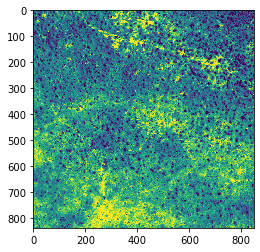

<Figure size 504x504 with 0 Axes>

In [104]:
plt.imshow(img[0], interpolation='nearest')
plt.figure(figsize=(7,7))
plt.show()

In [ ]:
for i in range(5):
    for j in range(5):
        